I will be retraining the model(s) with different configs, so I want to compare results here.

Experiments:

0. (baseline) Only trained on grants data points, config file 2021.03.16.ini, models in `models/210316/`
1. Remove stop words for count and tfidf vectorizers
2. 1 + Don't train using grant types. Bit worried that since the training set is so small it might overfit to these.
3. 1 + 2 + Apply clean_string to grants text
4. 1 + Apply clean_string to grants text
5. 1 + Apply clean_string to grants text + trained on 42 Grants title, grant type and synopsis

And I will
- Train/test on grants only data points (2021.03.08 training data)
- Same model parameters: relevant_sample_ratio = 1, test_size = 0.25, split_seed = 1
- No BERT or SciBERT models (time reasons)
- See how well this extends to predict the RF and EPMC data points (2021.03.29 training data).

## Findings

There is quite a lot of variation in the results from the different models. The trends remain the same regardless of experiment.

The average metrics of all models reveal that the best experiment is `remove stop words + clean strings + training data from 42` (experiment 5). This gives highest test recall and precision, and good EPMC evaluation metric.

It appears that the exclusion of the grant type data made the models perform worse.

|Metric|Experiment 0|Experiment 4|Experiment 5|
|---|---|---|---|
|Test precision (average of all models) | 0.791|0.822|0.825|
|Test recall (average of all models) | 0.829|0.833|0.848|
|Test precision (42 data) (average of all models) | 0.797|0.822|-|
|Test recall (42 data) (average of all models) | 0.867|0.844|-|
|EPMC accuracy (average of all models) | 0.676|0.706|0.699|
|RF accuracy (average of all models) | 0.514|0.524|0.510|

Note: When using the 42 data in the training the evaluation using 42 data is the same as the test metrics. Thus the 42 data evaluation is only really interesting to see how well the 360 giving data translates to 42 data.

In [1]:
import json
import ast

import pandas as pd
import numpy as np
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    f1_score,
    precision_score,
    recall_score,
)
import matplotlib.pyplot as plt

In [2]:
cd ..

/Users/gallaghe/Code/nutrition-labels


In [3]:
from nutrition_labels.grant_tagger import GrantTagger

In [4]:
# Extra grants information I got from forty two for the grants in the 210308 training data (plus RF and EPMC)
extra_grants_info = pd.read_csv('data/processed/fortytwo/tech_210308_training_data_fortytwo_info.csv')

In [5]:
## Get the EPMC and RF evaluation data and merge with the neccessary text
## NOTE: This is only 'tech' data points

def merge_eval_grants(evaluation_data, grants_data, extra_grants_info):

    evaluation_data = pd.merge(
        evaluation_data,
        grants_data.drop_duplicates(subset="Internal ID")[
            ["Title", "Grant Programme:Title", "Description", "Internal ID"]
        ],
        how="left",
        left_on="Internal ID",
        right_on="Internal ID",
    )
    evaluation_data = pd.merge(
        evaluation_data,
        extra_grants_info.drop_duplicates(subset="Reference")[
            ["Reference", "Synopsis", "Master Grant Type Name"]
        ],
        how="left",
        left_on="Internal ID",
        right_on="Reference",
    )
    
    evaluation_data['Relevance code'] = evaluation_data['Relevance code'].astype(int)
    return evaluation_data

grants_data = pd.read_csv('data/raw/wellcome-grants-awarded-2005-2019.csv')

epmc_evaluation_data = pd.read_csv('data/processed/training_data/210329epmc/training_data.csv')
rf_evaluation_data = pd.read_csv('data/processed/training_data/210329rf/training_data.csv')

epmc_evaluation_data = merge_eval_grants(epmc_evaluation_data, grants_data, extra_grants_info)
rf_evaluation_data = merge_eval_grants(rf_evaluation_data, grants_data, extra_grants_info)

In [48]:
# Forty two descriptions with test data set

model_date = '210316'
training_info_file = f'models/{model_date}/training_information.json'
with open(training_info_file, 'r') as file:
    for line in file:
        model_data = json.loads(line)
        
# The true test data is the same for each model so just pick tfidf_log_reg_210316 one.
test_data = pd.DataFrame([(k, v['Truth']) for k, v in model_data['tfidf_log_reg_210316'].items() if v['Test/train']=='Test'])
print(len(test_data))
test_data = test_data.rename({0:"Internal ID", 1:'Relevance code'}, axis='columns')

# Merge the test data with the fortytwo info when given (inner join)
test_data_42 = pd.merge(
        test_data,
        extra_grants_info.drop_duplicates(subset="Reference")[
            ['Reference','Synopsis', 'Title', 'Master Grant Type Name']
        ],
        how="inner",
        left_on='Internal ID',
        right_on="Reference",
    )
test_data_42 = test_data_42.rename(
    {'Synopsis': 'Description', 'Master Grant Type Name': 'Grant Programme:Title'}, 
    axis='columns'
)

print(len(test_data_42))

157
157


In [7]:
def get_score(true_pred_values):
    y_true = [t[0] for t in true_pred_values]
    y_pred = [t[1] for t in true_pred_values]
    
    return {
        'f1': f1_score(y_true, y_pred),
      'precision_score': precision_score(y_true, y_pred),
      'recall_score': recall_score(y_true, y_pred)
    }

In [8]:
def get_performance(model_name, model_training_info, model_date, epmc_evaluation_data, rf_evaluation_data, test_data_42):
    
    test_values = [(values['Truth'], values['Prediction']) \
                   for values in model_training_info if values['Test/train'] == 'Test']
    train_values = [(values['Truth'], values['Prediction']) \
                    for values in model_training_info if values['Test/train'] == 'Train']
    test_scores = get_score(test_values)
    train_scores = get_score(train_values)
    
    # Evaluate model on evaluation data
    
    def evaluate_data(evaluation_data, grant_tagger):
        prediction_cols = list(grant_tagger.prediction_cols)
        X_eval = evaluation_data[prediction_cols].agg(". ".join, axis=1).tolist()
        X_vect_eval = grant_tagger.vectorizer.transform(X_eval) 
        y_eval = evaluation_data["Relevance code"].tolist()
        eval_scores = grant_tagger.evaluate(X_vect_eval, y_eval)
        return eval_scores
    
    grant_tagger = GrantTagger()
    grant_tagger.load_model(f'models/{model_date}/{model_name}')
    epmc_eval_scores = evaluate_data(epmc_evaluation_data, grant_tagger)
    rf_eval_scores = evaluate_data(rf_evaluation_data, grant_tagger)
    test_data_42_scores = evaluate_data(test_data_42, grant_tagger)
    
    return {
        'train_scores': train_scores,
        'test_scores': test_scores,
        'epmc_eval_scores': epmc_eval_scores,
        'rf_eval_scores': rf_eval_scores,
        '42_eval_scores': test_data_42_scores
    }

## Experiment results function

In [9]:
def get_experiment_scores(model_date, epmc_evaluation_data, rf_evaluation_data, test_data_42):
    training_info_file = f'models/{model_date}/training_information.json'
    all_models_evaluation = {}
    with open(training_info_file, 'r') as file:
        for line in file:
            model_data = json.loads(line)
            model_name = list(model_data.keys())[0]
            if 'bert' not in model_name:
                all_models_evaluation[model_name] = get_performance(
                    model_name,
                    model_data[model_name].values(),
                    model_date,
                    epmc_evaluation_data,
                    rf_evaluation_data,
                    test_data_42
                )
    return all_models_evaluation

In [10]:
def get_one_score(row):
    d = []
    for i, r in zip(row.index, row):
        d.append(r[plot_dict[i]])
    return d

In [11]:
def get_one_score(row):
    d = []
    for i, r in zip(row.index, row):
        values = plot_dict[i]
        if type(values)==list:
            for value in values:
                d.append(r[value])
        else:
            d.append(r[values])
    return d

In [12]:
plot_dict = {'train_scores': 'f1', 'test_scores': ['precision_score','recall_score'],'epmc_eval_scores': 'accuracy', 'rf_eval_scores': 'accuracy', '42_eval_scores': ['precision_score','recall_score']}
plot_dict_names = ['train f1', 'test precision', 'test recall', 'epmc_eval accuracy', 'rf_eval accuracy', '42 test precision', '42 test recall']

## 0. (baseline) Only trained on grants data points, config file 2021.03.16.ini, models in models/210316/

In [49]:
model_date = '210316'
experiment0_evaluation = get_experiment_scores(model_date, epmc_evaluation_data, rf_evaluation_data, test_data_42)

In [50]:
experiment0_scores = pd.DataFrame(experiment0_evaluation).apply(get_one_score, axis=0)
experiment0_scores.index = plot_dict_names

## 1. Remove stop words for count and tfidf vectorizers

In [51]:
model_date = '2103291'
experiment1_evaluation = get_experiment_scores(model_date, epmc_evaluation_data, rf_evaluation_data, test_data_42)

In [52]:
experiment1_scores = pd.DataFrame(experiment1_evaluation).apply(get_one_score, axis=0)
experiment1_scores.index = plot_dict_names

## 2. Remove stop words + Don't train using grant types

In [53]:
model_date = '2103292'
experiment2_evaluation = get_experiment_scores(model_date, epmc_evaluation_data, rf_evaluation_data, test_data_42)

In [54]:
experiment2_scores = pd.DataFrame(experiment2_evaluation).apply(get_one_score, axis=0)
experiment2_scores.index = plot_dict_names

## 3. Remove stop words + Don't train using grant types + apply clean_text

In [55]:
model_date = '2103293'
experiment3_evaluation = get_experiment_scores(model_date, epmc_evaluation_data, rf_evaluation_data, test_data_42)

In [56]:
experiment3_scores = pd.DataFrame(experiment3_evaluation).apply(get_one_score, axis=0)
experiment3_scores.index = plot_dict_names

## 4. Remove stop words + apply clean_text

In [57]:
model_date = '2103294'
experiment4_evaluation = get_experiment_scores(model_date, epmc_evaluation_data, rf_evaluation_data, test_data_42)

In [58]:
experiment4_scores = pd.DataFrame(experiment4_evaluation).apply(get_one_score, axis=0)
experiment4_scores.index = plot_dict_names

## 5. Remove stop words + apply clean_text + trained on 42 texts

In [59]:
model_date = '2103295'
experiment5_evaluation = get_experiment_scores(model_date, epmc_evaluation_data, rf_evaluation_data, test_data_42)

In [60]:
experiment5_scores = pd.DataFrame(experiment5_evaluation).apply(get_one_score, axis=0)
experiment5_scores.index = plot_dict_names

## Comparison

In [61]:
def scores_for_plots(scores):
    sort_order = ['count_SVM', 'count_log_reg', 'tfidf_SVM', 'tfidf_log_reg', 'count_naive_bayes', 'tfidf_naive_bayes']
    scores = scores.rename(lambda x: '_'.join(x.split('_')[:-1]), axis='columns')
    scores = scores[sort_order]
    return scores

In [62]:
experiment0_scores_renamed = scores_for_plots(experiment0_scores)
experiment1_scores_renamed = scores_for_plots(experiment1_scores)
experiment2_scores_renamed = scores_for_plots(experiment2_scores)
experiment3_scores_renamed = scores_for_plots(experiment3_scores)
experiment4_scores_renamed = scores_for_plots(experiment4_scores)
experiment5_scores_renamed = scores_for_plots(experiment5_scores)

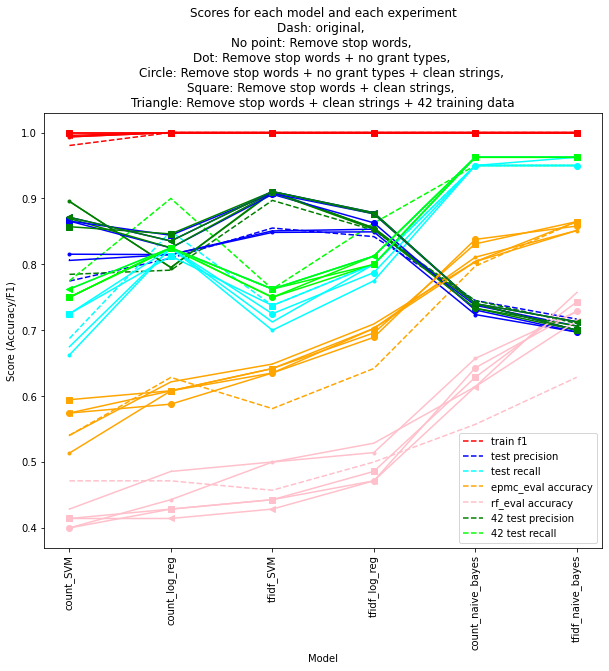

In [63]:
plt.figure(figsize=(10,8))

colours = ['red','blue','cyan','orange','pink','green','lime']
for i, (metric_type, row) in enumerate(experiment0_scores_renamed.iterrows()):
    plt.plot(row, color = colours[i], label=metric_type, linestyle='--')
for i, (_, row) in enumerate(experiment1_scores_renamed.iterrows()):
    plt.plot(row, color = colours[i], marker=',')
for i, (_, row) in enumerate(experiment2_scores_renamed.iterrows()):
    plt.plot(row, color = colours[i], marker='.')
for i, (_, row) in enumerate(experiment3_scores_renamed.iterrows()):
    plt.plot(row, color = colours[i], marker='o')
for i, (_, row) in enumerate(experiment4_scores_renamed.iterrows()):
    plt.plot(row, color = colours[i], marker='s')
for i, (_, row) in enumerate(experiment5_scores_renamed.iterrows()):
    plt.plot(row, color = colours[i], marker='<')
plt.xticks(rotation=90)

plt.xlabel('Model')
plt.ylabel('Score (Accuracy/F1)')
plt.title('Scores for each model and each experiment\nDash: original, \nNo point: Remove stop words, \nDot: Remove stop words + no grant types, \nCircle: Remove stop words + no grant types + clean strings, \nSquare: Remove stop words + clean strings, \nTriangle: Remove stop words + clean strings + 42 training data')
plt.legend()
plt.show()


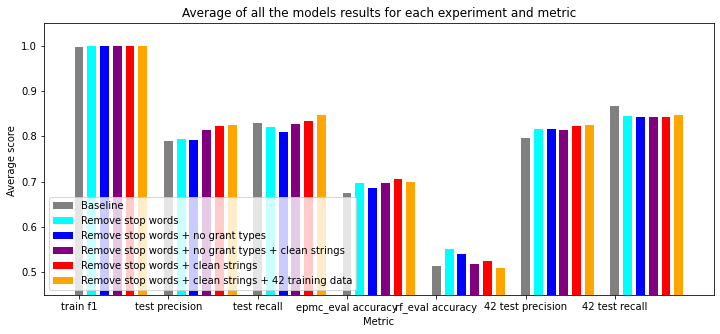

In [64]:
fig, ax = plt.subplots(figsize=(12,5))

colours = ['grey','cyan','blue','purple','red', 'orange']

metrics = experiment0_scores_renamed.index
exp_desc = ['Baseline', 'Remove stop words',
            'Remove stop words + no grant types',
            'Remove stop words + no grant types + clean strings',
            'Remove stop words + clean strings',
           'Remove stop words + clean strings + 42 training data']
for i, data in enumerate(
    [experiment0_scores_renamed, experiment1_scores_renamed,
experiment2_scores_renamed,experiment3_scores_renamed,experiment4_scores_renamed,
    experiment5_scores_renamed]):
    x_shift = i/7
    plt.bar(
        [v+x_shift for v in [0,1,2,3,4,5,6]],
        data.mean(axis=1), width=0.1,
        label=exp_desc[i], color=colours[i])

plt.xlabel('Metric')
plt.ylabel('Average score ')
ax.set_xticks(range(0,7))
ax.set_xticklabels(metrics)
plt.ylim(0.45,1.05)
plt.title('Average of all the models results for each experiment and metric')
ax.legend(loc='lower left')
plt.show()

In [65]:
def print_values(metric):
    print(round(experiment0_scores_renamed.loc[metric].mean(), 3))
#     print(round(experiment1_scores_renamed.loc[metric].mean(), 3))
#     print(round(experiment2_scores_renamed.loc[metric].mean(), 3))
#     print(round(experiment3_scores_renamed.loc[metric].mean(), 3))
    print(round(experiment4_scores_renamed.loc[metric].mean(), 3))
    print(round(experiment5_scores_renamed.loc[metric].mean(), 3))

In [66]:
print_values('test precision')
print('--')
print_values('test recall')
print('--')
print_values('epmc_eval accuracy')
print('--')
print_values('rf_eval accuracy')
print('--')
print_values('42 test precision')
print('--')
print_values('42 test recall')

0.791
0.822
0.825
--
0.829
0.833
0.848
--
0.676
0.706
0.699
--
0.514
0.524
0.51
--
0.797
0.822
0.825
--
0.867
0.844
0.848
